In [13]:
import gymnasium as gym
import numpy as np

In [20]:
env = gym.make("Pendulum-v1", g=9.81)
env.reset()
print(env.observation_space.shape)
print(env.action_space.shape)
print(np.issubdtype(
        type(env.action_space.sample()),
        np.integer))
print(env.action_space.sample().shape)
action_lowbound = env.action_space.low[0]
action_upbound = env.action_space.high[0]
print(action_lowbound)
print(action_upbound)
isinstance(env.action_space, gym.spaces.Discrete)

(3,)
(1,)
False
(1,)
-2.0
2.0


False

In [19]:
env_new = gym.make("CartPole-v1")
env_new.reset()
print(env_new.observation_space.shape)
print(env_new.action_space.shape)
print(np.issubdtype(
        type(env_new.action_space.sample()),
        np.integer))
print(env_new.action_space.sample().shape)
isinstance(env_new.action_space, gym.spaces.Discrete)

(4,)
()
True
()


True

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import savgol_filter
import seaborn as sns

def plot_training_metrics(
    base_dir,
    folders,
    target_env,
    smooth_method='moving_average',
    smooth_window=20,
    savgol_polyorder=3,
    figsize=(24, 6),
    color_map='tab10',
    save_path=None
):
    """
    绘制指定文件夹中最新的训练指标（如 loss、maxq、reward）并进行平滑处理的图表。

    参数:
    - base_dir (str): 包含指标文件夹的基目录路径。
    - folders (list of str): 指标文件夹的名称列表（例如 ['loss', 'maxq', 'reward']）。
    - target_env (str): 目标环境前缀（例如 'LunarLander'）。
    - smooth_method (str): 平滑方法，'moving_average' 或 'savgol'。默认值为 'moving_average'。
    - smooth_window (int): 平滑窗口大小。对于移动平均，窗口越大，平滑效果越明显；对于 Savitzky-Golay 滤波器，窗口大小必须为奇数。默认值为 20。
    - savgol_polyorder (int): Savitzky-Golay 滤波器的多项式阶数。默认值为 3。
    - figsize (tuple): 图表的大小。默认值为 (24, 6)。
    - color_map (str or matplotlib.colors.Colormap): 用于绘制不同方法的颜色映射。默认值为 'tab10'。
    - save_path (str, optional): 如果提供，将图表保存到指定路径，而不是仅显示。默认值为 None。

    返回:
    - None
    """

    def get_latest_files(folder, target_env):
        """
        从指定文件夹中获取每个方法最新的 CSV 文件。

        仅处理以 target_env 为环境前缀的文件。

        参数:
        - folder (str): 文件夹名称（例如 'loss', 'maxq', 'reward'）
        - target_env (str): 目标环境前缀（例如 'LunarLander'）

        返回:
        - dict: 键为方法名称，值为对应最新文件的完整路径
        """
        folder_path = os.path.join(base_dir, folder)
        try:
            files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
        except FileNotFoundError:
            print(f"文件夹 {folder_path} 不存在。")
            return {}

        latest_files = {}

        for file in files:
            # 检查文件是否以目标环境前缀开头
            if not file.startswith(f"{target_env}_"):
                continue  # 跳过其他环境的文件

            parts = file.rstrip('.csv').split('_')
            if len(parts) < 3:
                print(f"文件名格式不符合要求，跳过: {file}")
                continue  # 跳过不符合命名规则的文件

            environment = parts[0]
            method = parts[1]
            timestamp_str = '_'.join(parts[2:])  # 处理包含多个下划线的时间戳

            if environment != target_env:
                continue  # 再次确保环境前缀匹配

            try:
                # 假设时间戳格式为 'YYYY-MM-DD-HH-MM'
                timestamp = datetime.strptime(timestamp_str, '%Y-%m-%d-%H-%M')
            except ValueError:
                print(f"无法解析时间戳: {timestamp_str} in file {file}")
                continue  # 跳过无法解析的时间戳

            # 如果当前方法还没有记录，或者当前文件的时间戳更晚，则更新
            if (method not in latest_files) or (timestamp > latest_files[method][0]):
                latest_files[method] = (timestamp, file)

        # 构建方法到文件路径的映射
        return {method: os.path.join(folder_path, file_info[1]) for method, file_info in latest_files.items()}

    def smooth_data(df, method='moving_average', window=5, polyorder=3):
        """
        对数据进行平滑处理。

        参数:
        - df (pd.DataFrame): 包含 'Step' 和 'Value' 列的 DataFrame
        - method (str): 平滑方法，'moving_average' 或 'savgol'
        - window (int): 窗口大小
        - polyorder (int): 多项式阶数（仅适用于 Savitzky-Golay 滤波器）

        返回:
        - pd.DataFrame: 包含 'Step' 和 'Smoothed_Value' 列的 DataFrame
        """
        if method == 'moving_average':
            df['Smoothed_Value'] = df['Value'].rolling(window=window, min_periods=1).mean()
        elif method == 'savgol':
            # 确保窗口大小为奇数且不超过数据长度
            if window % 2 == 0:
                window += 1
            if window > len(df):
                window = len(df) if len(df) % 2 != 0 else len(df)-1
            try:
                df['Smoothed_Value'] = savgol_filter(df['Value'], window_length=window, polyorder=polyorder)
            except ValueError as e:
                print(f"Savitzky-Golay 滤波器错误: {e}")
                df['Smoothed_Value'] = df['Value']  # 回退到原始数据
        else:
            df['Smoothed_Value'] = df['Value']  # 未平滑
        return df

    # 设置绘图风格
    # sns.set_style("darkgrid")

    # 获取每个文件夹中最新的文件，且仅包含目标环境的文件
    latest_files_dict = {folder: get_latest_files(folder, target_env) for folder in folders}

    # 获取所有唯一的方法名称
    all_methods = set()
    for folder in folders:
        all_methods.update(latest_files_dict[folder].keys())

    all_methods = sorted(all_methods)  # 排序以保持一致的颜色顺序

    if not all_methods:
        print("未找到任何符合条件的方法。请检查文件夹和环境前缀。")
        return

    # 颜色映射
    if isinstance(color_map, str):
        colors = plt.cm.get_cmap(color_map).colors  # 获取颜色列表
    else:
        colors = color_map  # 直接使用传入的 Colormap 对象

    # 定义每个文件夹对应的 Y 轴标签
    ylabel_map = {
        'loss': 'Loss',
        'maxq': 'Max Q-value',
        'reward': 'Reward'
    }

    # 创建子图
    fig, axes = plt.subplots(1, len(folders), figsize=figsize, sharex=False)

    # 如果只有一个文件夹，axes 不是列表，需要转换为列表
    if len(folders) == 1:
        axes = [axes]

    # 绘制每个文件夹的子图
    for idx, folder in enumerate(folders):
        ax = axes[idx]
        ylabel = ylabel_map.get(folder, 'Value')

        for i, method in enumerate(all_methods):
            file_path = latest_files_dict[folder].get(method)
            if not file_path:
                continue  # 当前文件夹中没有该方法的文件

            try:
                df = pd.read_csv(file_path)
            except Exception as e:
                print(f"读取文件 {file_path} 时出错: {e}")
                continue  # 跳过无法读取的文件

            # 检查必要的列是否存在
            if 'Step' not in df.columns or 'Value' not in df.columns:
                print(f"文件 {file_path} 缺少 'Step' 或 'Value' 列。")
                continue

            # 应用平滑处理
            df = smooth_data(df, method=smooth_method, window=smooth_window, polyorder=savgol_polyorder)

            # 绘制平滑后的数据
            ax.plot(df['Step'], df['Smoothed_Value'], label=method, color=colors[i % len(colors)], linewidth=2)

        ax.set_title(f"{ylabel} - {target_env}")
        ax.set_xlabel('Step')
        ax.set_ylabel(ylabel)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"图表已保存到 {save_path}")
    else:
        plt.show()


C:\Users\runze\AppData\Local\Temp\ipykernel_19052\3592064807.py:139: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(color_map).colors  # 获取颜色列表


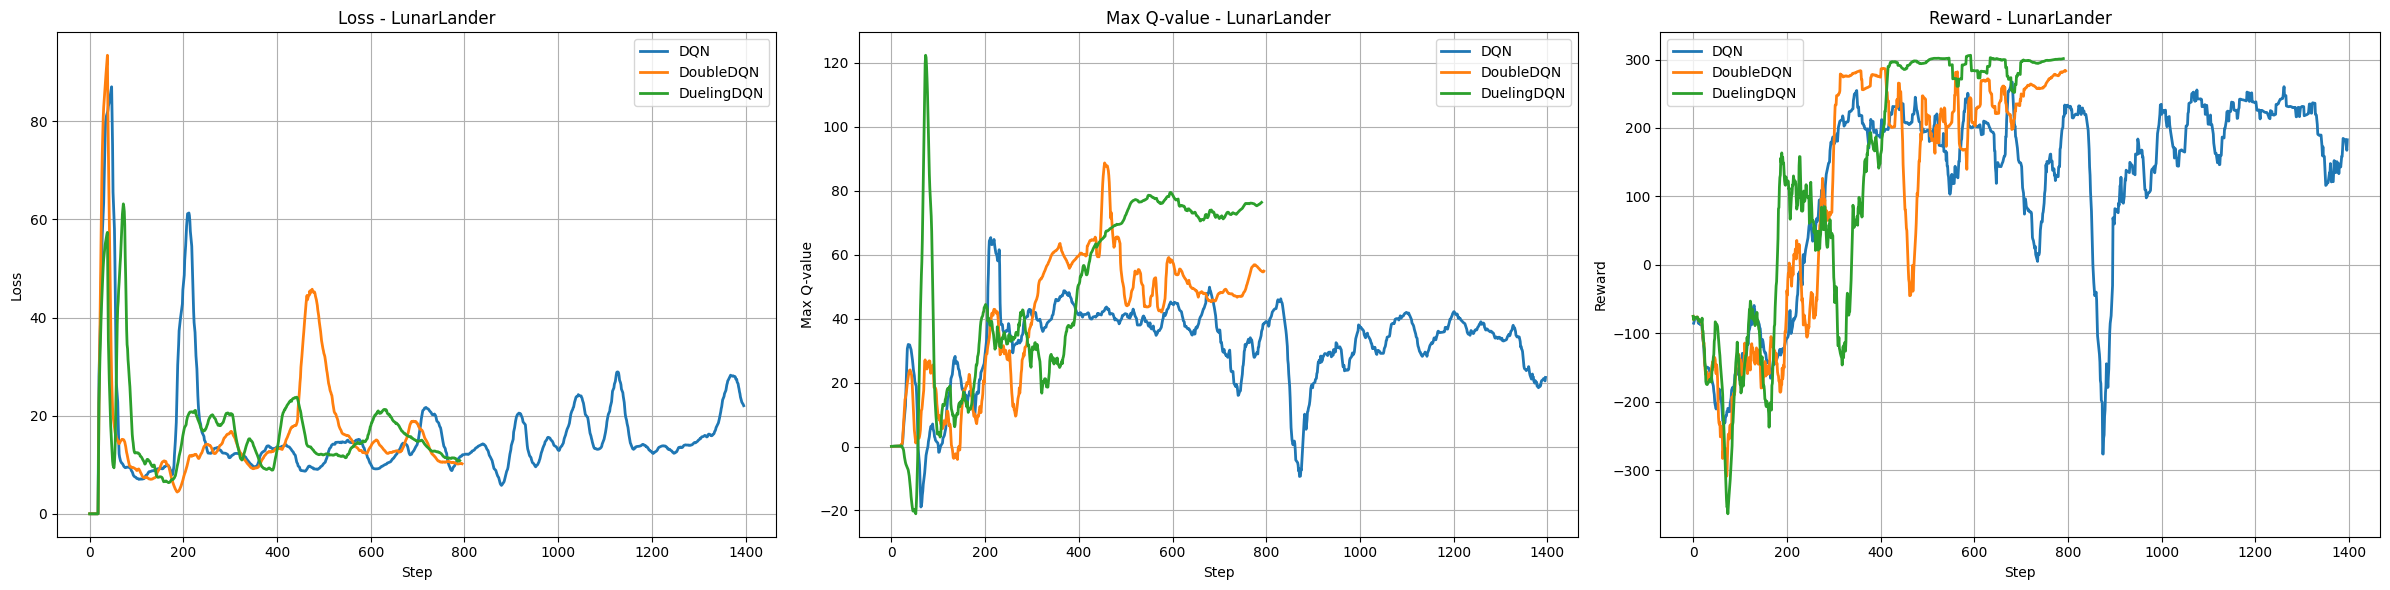

In [20]:
base_directory = './logs'
metric_folders = ['loss', 'maxq', 'reward']
target_environment = 'LunarLander'
# 调用函数绘制图表
plot_training_metrics(
    base_dir=base_directory,
    folders=metric_folders,
    target_env=target_environment,
    smooth_method='moving_average',  # 或 'savgol'
    smooth_window=20,               # 根据需要调整
    savgol_polyorder=3,             # 仅适用于 'savgol' 方法
    figsize=(24, 6),
    color_map='tab10',
    save_path=None                   # 如果需要保存图像，提供文件路径，例如 'metrics_plot.png'
)

C:\Users\runze\AppData\Local\Temp\ipykernel_19052\3592064807.py:139: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(color_map).colors  # 获取颜色列表


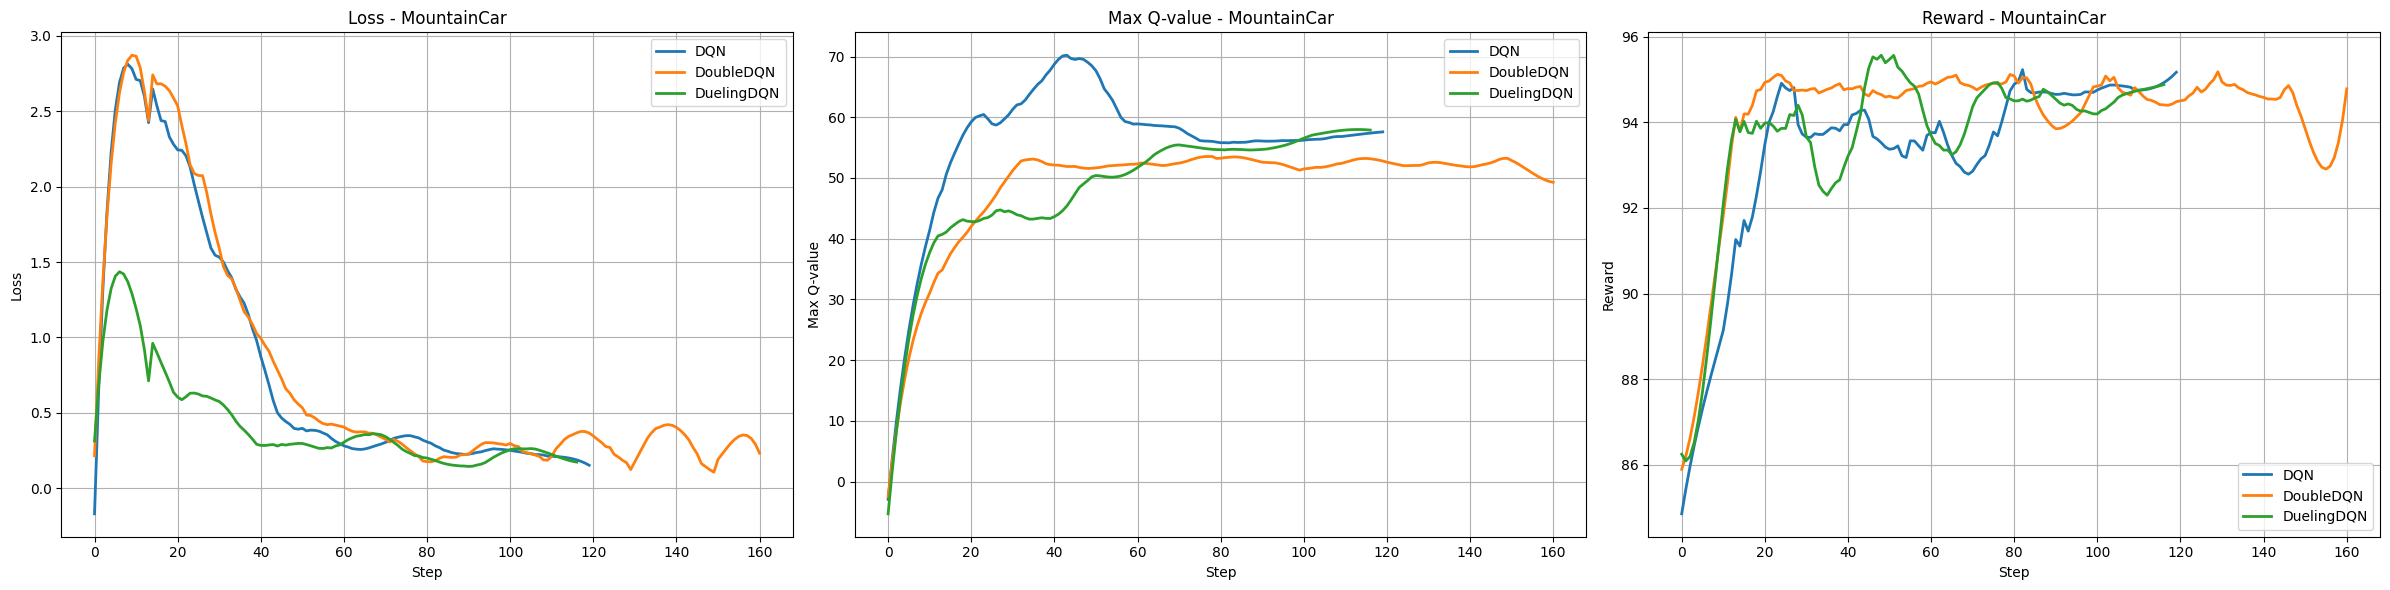

In [7]:
target_environment = 'MountainCar'

plot_training_metrics(
    base_dir=base_directory,
    folders=metric_folders,
    target_env=target_environment,
    smooth_method='savgol',  # 或 'savgol'
    smooth_window=20,               # 根据需要调整
    savgol_polyorder=3,             # 仅适用于 'savgol' 方法
    figsize=(24, 6),
    color_map='tab10',
    save_path=None                   # 如果需要保存图像，提供文件路径，例如 'metrics_plot.png'
)

C:\Users\runze\AppData\Local\Temp\ipykernel_19052\3592064807.py:139: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(color_map).colors  # 获取颜色列表


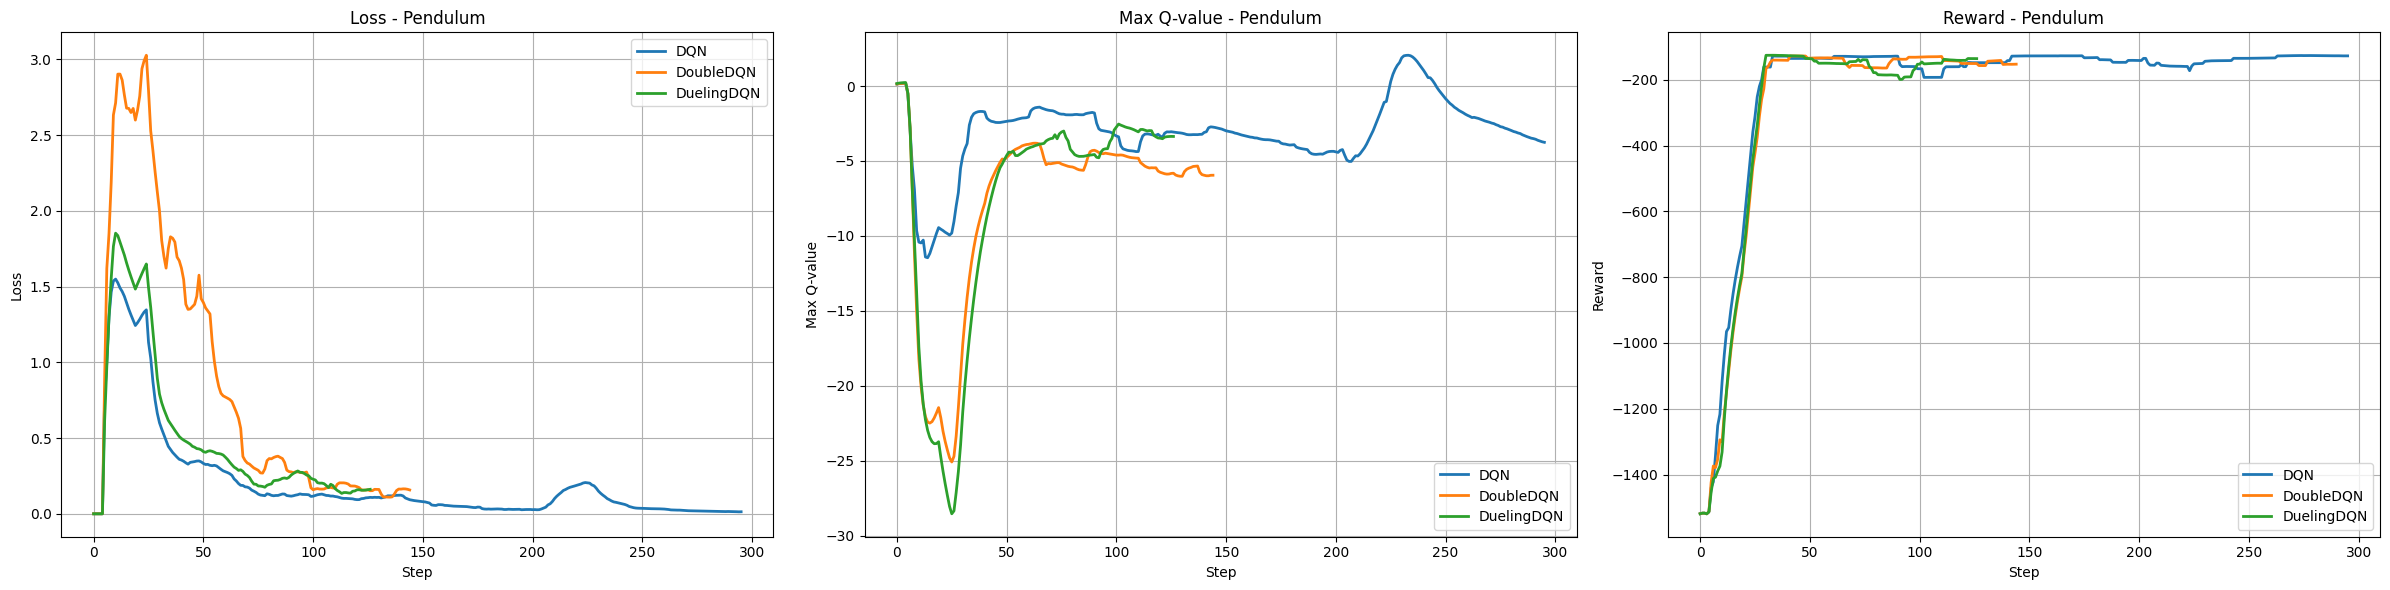

In [10]:
target_environment = 'Pendulum'

plot_training_metrics(
    base_dir=base_directory,
    folders=metric_folders,
    target_env=target_environment,
    smooth_method='moving_average',  # 或 'savgol'
    smooth_window=20,               # 根据需要调整
    savgol_polyorder=3,             # 仅适用于 'savgol' 方法
    figsize=(24, 6),
    color_map='tab10',
    save_path=None                   # 如果需要保存图像，提供文件路径，例如 'metrics_plot.png'
)